# *Living Earth* Observed change
# Mapping conversions and modifications of land cover
<img align="right" src="../../Supplementary_data/dea_logo.jpg">

* **[Sign up to the DEA Sandbox](https://app.sandbox.dea.ga.gov.au/)** to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with `DEA Sandbox` environment
* **Products used:** 
[ga_s2am_ard_3](https://explorer.dea.ga.gov.au/products/ga_s2am_ard_3)


## Overview of observed changes

**Land Cover** is the physical and biological cover of the land surface and includes vegetation (managed or semi-natural), water and bare surfaces.  The land cover maps generated through Living Land Management use the legends of the United Nation's Food and Agriculture Organisation (FAO) Land Cover Classification System (LCCS).

Transitions between any two Level 3 land cover types (off-diagonals in a transition matrix) correspond to a change in extent in both the original class at the time of the first observation (T1) and the replacement class in the second observation (T2) (i.e., a land cover **conversion**). More detailed descriptions of the land cover class prior to and following the change can be provided by referencing the categorical and continuous environmental descriptors used in the construction of the FAO LCCS classes at T1 and T2 respectively as well as AEDs. 

Where the Level 3 class remains the same between time-separated periods (the on-diagonals in the transition matrix), a modification rather than conversion of the land cover occurs and only changes in the amounts or type of state indictors within the Level 3 class can take place. These changes can only be described by considering variations (decreases, increases or no difference) in what are termed Essential Environmental Descriptors (EEDs) that are required to construct the FAO LCCS or Additional Environmental Descriptors (AEDs) that are not required but provide additional descriptors.  These descriptors can be units of measurements (or categorizations of these; e.g. canopy cover in %) or simply a change in a pre-defined category (e.g., representing lifeform or leaf type).



## Description 

Through Geoscience Australia's (GA) Digital Earth Australia (DEA) Land Cover, land cover maps have been generated for 34 years (1988 to 2020) from environmental descriptors retreived or classified entirely from Landsat sensor data and according to the Food and Agriculture Organisation (FAO) Land Cover Classification System (Version 2).  The spatial resolution of the mapping is 25 m 
(see DEA Land Cover) at https://cmi.ga.gov.au/data-products/dea/607/dea-land-cover-landsat)

For a selected area of interest, the notebook compares land cover data for any two years and generates maps of conversions (changes in extent) or modifications (no changes in extent but a change in type (e.g. lifeform) or condition of land covers).

1. Loading and displaying DEA land cover classifications (basic and detailed) and contributing environmental descriptors for an area of interest.
2. Determing areas of land cover conversions (losses and gains) based on time-series comparison of the land cover maps between two years.
3. Determining areas of no change in the FAO LCCS Level 3 classes where there is potential for a modification to occur. 

This notebook requires a basic understanding of the DEA Land Cover data set. 
If you are new to DEA Land Cover, it is recommended you look at the introductory [DEA Land Cover notebook](../DEA_datasets/DEA_Land_Cover.ipynb) first. 

This notebook requires a basic understanding of the DEA Land Cover data set. 
If you are new to DEA Land Cover, it is recommended you look at the introductory [DEA Land Cover notebook](../DEA_datasets/DEA_Land_Cover.ipynb) first. 

***

## Getting started

To run this analysis, run all the cells in the notebook starting with the 'Load packages and connect to the datacube' cell.

In [1]:
# Initial imports and setup
import sys
import os, re
import matplotlib.pyplot as plt
from matplotlib import colors as mcolours

import xarray as xr
import numpy as np

import odc.stac
import pystac_client
from odc.geo import BoundingBox
from odc.geo.cog import write_cog
from odc.geo.xr import assign_crs

from dea_tools.plotting import display_map
from dea_tools.landcover import lc_colourmap, make_colourbar, plot_land_cover

### Load packages

Load key Python packages and supporting functions for the analysis, then connect to the datacube. 

### Connect to the datacube
Connect to the datacube so we can access DEA data. 

In [2]:
# Configure data access
odc.stac.configure_s3_access(cloud_defaults=True, aws_unsigned=True)

# Connect to STAC API
catalog = pystac_client.Client.open("https://explorer.dea.ga.gov.au/stac")

## Select and view your study area

**If running the notebook for the first time,** keep the default settings below.
This will demonstrate how the change mapping functionality works and provide meaningful results.
The following example loads land cover data over Mount Ney in Western Australia, a region which has experienced extensive bushfires and variations in water inundation over the 34 years of observation.  

**NOTE:  You can change the area of interest and also the time range in subsequent user-selected runs of the notebook.

In [3]:
product='ga_ls_landcover_class_cyear_3'

# Set the range of dates for the analysis
time_range = ("1988", "2024")

# Coordinates for Broome, Western Australia
#central_lat = -18.10
#central_lon = 122.32

# Sydney, New South Wales, Australia
central_lat = -33.9
central_lon = 151.24

buffer = 0.2
resolution=30
crs='EPSG:3577'

In [4]:
#set up a bounding box for our stac query 
bbox = BoundingBox(
    left=central_lon - buffer,
    bottom=central_lat - buffer,
    right=central_lon + buffer,
    top=central_lat + buffer,
    crs=crs
)
bbox_query = bbox.bbox

# Search the catalog for matching S2 data
query = catalog.search(
    bbox=bbox_query,
    collections=[product],
    datetime=time_range
    )

items = list(query.items()) #convert to list
print(f"Found: {len(items):d} datasets")

Found: 74 datasets


In [5]:
# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)
display_map(x=study_area_lon, y=study_area_lat)

# Define dates and/or period of interest


#### Load and reproject CCI Biomass data

## 3.1  Observed change
The observed change considers conversions (i.e., changes in extent of the Level 3 classes) and modification (i.e., the level 3 class remains the same but there are changes in categorical (e.g., lifeform) or continuous (e.g., water hydroperiod) environmental descriptors.  

### Plot broad land cover types over the time-series

## Load and view the FAO LCCS Level 3 data
The following cell will load what are termed the Environmental Descriptors (EDs) used to construct the Basic (Level 3) and subsequently the Detailed (Level 4) land cover maps for the `lat_range`, `lon_range` and `time_range` defined for your area of interest.

You can view each of these layers using the  `plot_land_cover()` function.

** Note:  You can run one, several or all of these to view the appropriate product.

In [6]:
#now load the data with odc-stac
lc = odc.stac.load(
    items, #stac items
    bands=["level3", "level4"], #theses are the only two measurements
    crs=crs,
    resolution=resolution,
    groupby="solar_day",
    bbox=bbox, #area to load over
)

In [26]:
lc.level3[1]
unique_vals = np.unique(lc.level3.values)

print(unique_vals)

[-9223372036854775808                  111                  112
                  124                  215                  216
                  220]


### Level 3 change maps 

A first step towards developing a globally relevant and standardized taxonomy and framework for consistently describing land cover change was to establish the transition matrix between observed broad land cover classes (i.e., OEDs).  This stage was developed and is illustrated using the FAO LCCS given the dichotomous and then hierarchical modular structure of this taxonomy.  Between-class transitions and within-class changes can be identified by comparing these OEDs (i.e., the FAO LCCS Level 3 classes; 8 in total) between any two time-separated periods (i.e., T1 and T2), leading to 64 potential change categories; 56 on the off-diagonals and 8 on the on-diagonals.  

** Note:  There are 6 classes in the case of Australia as there are limited cultivated aquatic landscapes, and artificial and natural water are merged.

In the following steps, you will compare the earliest and latest Level 3 layers in selected time-series.

#### Select the start and end dates for comparisons of enviromental descriptors 
(e.g., Level 3, lifeform, vegetation cover, water state and level 4 (full classification))

#### ALL LEVEL 3 CHANGES

### GAINS

#### Change (gains) in Level 3 from 2010 [0] to 2020 [4 or -1]

In [27]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[0].astype(np.float32)
end = lc.level3[-1].astype(np.float32)
ignore_no_change = True
change_vals = (start * 1000) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)

In [28]:
level_3 = lc.level3[0].drop_vars("time")

In [29]:
# Create a new Xarray.DataArray
obs_gain_l3_2010_2020 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [30]:
obs_gain_l3 = obs_gain_l3_2010_2020.to_dataset(name="l3_2010_2020")
del obs_gain_l3_2010_2020

In [31]:
obs_gain_l3.l3_2010_2020
unique_vals = np.unique(obs_gain_l3.l3_2010_2020.values)

print(unique_vals)

[-9.223372e+21 -9.223372e+18  0.000000e+00  1.111120e+05  1.111240e+05
  1.112150e+05  1.112160e+05  1.112200e+05  1.121110e+05  1.121240e+05
  1.122150e+05  1.122160e+05  1.122200e+05  1.241110e+05  1.241120e+05
  1.242150e+05  1.242160e+05  1.242200e+05  2.151110e+05  2.151120e+05
  2.151240e+05  2.152160e+05  2.152200e+05  2.161110e+05  2.161120e+05
  2.161240e+05  2.162150e+05  2.162200e+05  2.201110e+05  2.201120e+05
  2.201240e+05  2.202150e+05  2.202160e+05]


### Plot Level 3 gains

In [14]:
# Define a colour scheme for the Level 3
LEVEL3_GAINS = {
    0: (255, 255, 255, 255, "No Change"),
    111112: (14, 121, 18, 255, " "),
    111123: (123, 243, 236, 255, " "),
    111124: (30, 191, 121, 255, " "),
    111215: (218, 92, 105, 255, " "),
    111216: (243, 171, 105, 255, " "),
    111220: (26, 84, 185, 255, " "),
    112111: (172, 188, 45, 255, " "),
    112123: (123, 243, 236, 255, " "),
    112124: (30, 191, 121, 255, " "),
    112215: (218, 92, 105, 255, " "),
    112216: (243, 171, 105, 255, " "),
    112220: (26, 84, 185, 255, " "),
    124111: (172, 188, 45, 255, " "),
    124112: (14, 121, 18, 255, " "),
    124123: (123, 243, 236, 255, " "),                               
    124215: (218, 92, 105, 255, " "),                                
    124216: (243, 171, 105, 255, " "), 
    124220: (26, 84, 185, 255, " "),                             
    215111: (172, 188, 45, 255, " "),
    215112: (14, 121, 18, 255, " "),
    215123: (123, 243, 236, 255, " "),
    215124: (30, 191, 121, 255, " "),                         
    215216: (243, 171, 105, 255, " "),
    215220: (26, 84, 185, 255, " "),
    216111: (172, 188, 45, 255, " "),
    216112: (14, 121, 18, 255, " "),
    216123: (123, 243, 236, 255, " "),
    216124: (30, 191, 121, 255, " "),    
    216215: (218, 92, 105, 255, " "),
    216220: (26, 84, 185, 255, " "),
    220111: (172, 188, 45, 255, " "),                                   
    220112: (14, 121, 18, 255, " "),
    220123: (123, 243, 236, 255, " "),
    220124: (30, 191, 121, 255, " "),                                       
    220215: (218, 92, 105, 255, " "),      
    220216: (243, 171, 105, 255, " ")}

In [15]:
import matplotlib.colors as mcolors

# Extract keys and RGBA values from LEVEL3_GAINS
codes = list(LEVEL3_GAINS.keys())
rgba_colors = [ (r/255, g/255, b/255, a/255) for (r,g,b,a,_) in LEVEL3_GAINS.values() ]

# Create a ListedColormap
cmap = mcolors.ListedColormap(rgba_colors, name='Level3')

In [16]:
# Map class codes to indices (0..N-1)
bounds = [i-0.5 for i in range(len(codes)+1)]  # boundaries between codes
norm = mcolors.BoundaryNorm(bounds, cmap.N)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


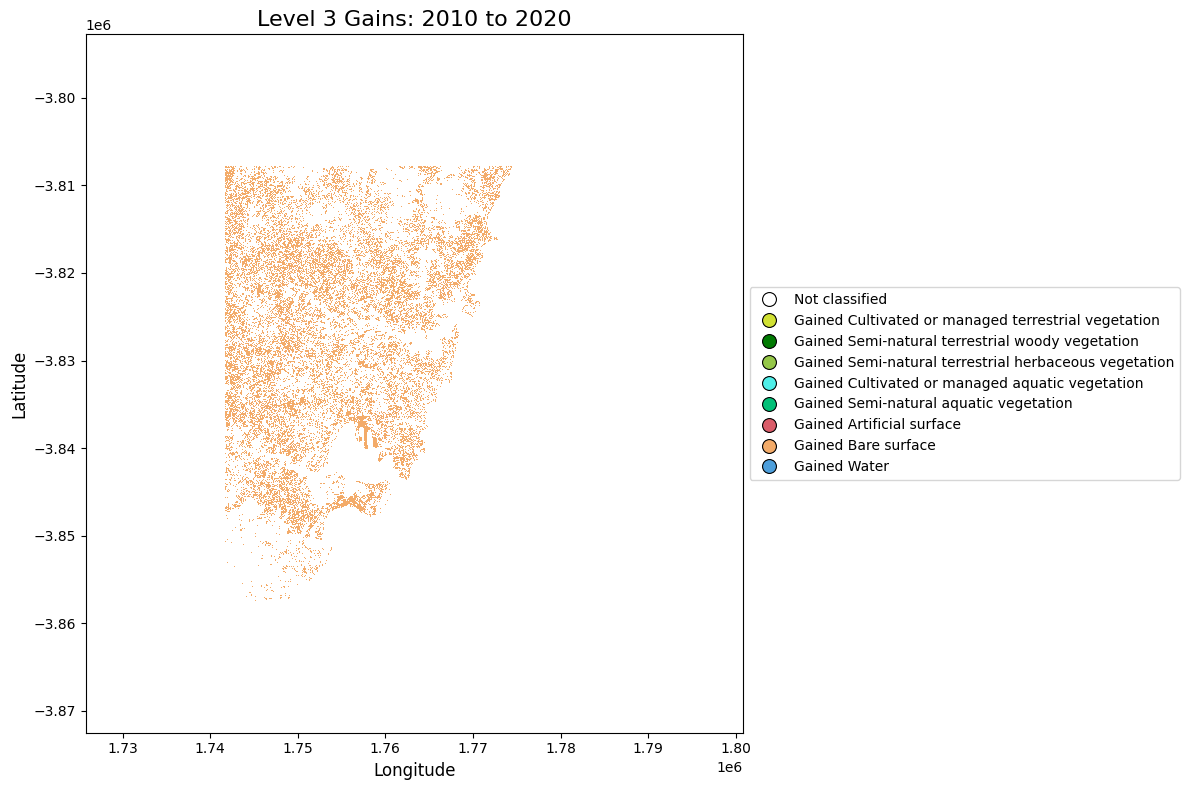

In [17]:
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd

# Sample code for plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the xarray data without the colorbar
c = obs_gain_l3.l3_2010_2020.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)

# Pretty plot options
ax.margins(0.05)
ax.set_aspect('equal', adjustable='datalim')
ax.set_xlabel('Longitude', fontsize=12)  # Set x-axis label
ax.set_ylabel('Latitude', fontsize=12)  # Set y-axis label
ax.set_title('Level 3 Gains: 2010 to 2020', fontsize=16)

# Create a custom legend
legend_colors = {
    "#FFFFFF": [0.0, "Not classified"],
    "#D1E133": [111.0, "Gained Cultivated or managed terrestrial vegetation"],
    "#007A02": [113.0, "Gained Semi-natural terrestrial woody vegetation"],
    "#95c748": [114.0, "Gained Semi-natural terrestrial herbaceous vegetation"],
    "#4EEEE8": [123.0, "Gained Cultivated or managed aquatic vegetation"],
    "#02C077": [124.0, "Gained Semi-natural aquatic vegetation"],
    "#DA5C69": [215.0, "Gained Artificial surface"],
    "#F3AB69": [216.0, "Gained Bare surface"],
    "#4D9FDC": [220.0, "Gained Water"],
}

legend_labels = [
    "Not classified",
    "Gained Cultivated or managed terrestrial vegetation",
    "Gained Semi-natural terrestrial woody vegetation",
    "Gained Semi-natural terrestrial herbaceous vegetation",
    "Gained Cultivated or managed aquatic vegetation",
    "Gained Semi-natural aquatic vegetation",
    "Gained Artificial surface",
    "Gained Bare surface",
    "Gained Water",
    
]

# Create custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                       markerfacecolor=color, markersize=10,
                     markeredgewidth=0.8, markeredgecolor='black') for label, color in zip(legend_labels, legend_colors)]

#ax.legend(handles=handles, loc='lower right', fontsize=10, title='', title_fontsize='13', frameon=True)
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, title='', title_fontsize='13', frameon=True)

plt.tight_layout()
plt.show()

#obs_gain_l3.l3_2010_2020.plot(cmap=cmap, norm=norm)

In [18]:
#This method uses the datacube.utils.cog function write_cog (where COG stands for Cloud Optimised GeoTIFF) 
#to export a simple single-band, single time-slice GeoTIFF file. A few important caveats should be noted when using this function:
#It requires an xarray.DataArray; supplying an xarray.Dataset will return an error. 

# Write GeoTIFF to a location
write_cog(geo_im=obs_gain_l3["l3_2010_2020"],
          fname='outputs/obs_gain_l3_2010_2020.tif',
          overwrite=True)

PosixPath('outputs/obs_gain_l3_2010_2020.tif')

### LOSSES

#### Identify change (loss) in Level 3 from 2010 [0] to 2020 [-1 or 4]

In [ ]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
# (Note changing to (end * 1000) + start
start = lc.level3[0].astype(np.float32)
end = lc.level3[-1].astype(np.float32)
ignore_no_change = True
change_vals = (end * 1000) + start
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
#level_3 = lc.level3[0].drop_vars("time")

In [ ]:
# Create a new Xarray.DataArray
obs_loss_l3_2010_2020= xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed losses",
    attrs=level_3.attrs,
    fastpath=False,
)

In [ ]:
obs_loss_l3 = obs_loss_l3_2010_2020.to_dataset(name="l3_2010_2020")
del obs_loss_l3_2010_2020

#### Change from 2017 [1] to 2018 [2]

#### Plot Level 3 losses

In [ ]:
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd

# Sample code for plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the xarray data without the colorbar
c = obs_loss_l3.l3_2010_2020.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)

# Pretty plot options
ax.margins(0.05)
ax.set_aspect('equal', adjustable='datalim')
ax.set_xlabel('Longitude', fontsize=12)  # Set x-axis label
ax.set_ylabel('Latitude', fontsize=12)  # Set y-axis label
ax.set_title('Level 3 losses: 2010 to 2020', fontsize=16)

# Create a custom legend
legend_colors = {
    "#FFFFFF": [0.0, "Not classified"],
    "#D1E133": [111.0, "Cultivated or managed terrestrial vegetation"],
    "#007A02": [113.0, "Semi-natural terrestrial woody vegetation"],
    "#95c748": [114.0, "Semi-natural terrestrial herbaceous vegetation"],
    "#4EEEE8": [123.0, "Cultivated or managed aquatic vegetation"],
    "#02C077": [124.0, "Semi-natural aquatic vegetation"],
    "#DA5C69": [215.0, "Artificial surface"],
    "#F3AB69": [216.0, "Bare surface"],
    "#4D9FDC": [220.0, "Water"],
}

legend_labels = [
    "Not classified",
    "Cultivated or managed terrestrial vegetation",
    "Semi-natural terrestrial woody vegetation",
    "Semi-natural terrestrial herbaceous vegetation",
    "Cultivated or managed aquatic vegetation",
    "Semi-natural aquatic vegetation",
    "Artificial surface",
    "Bare surface",
    "Water",
    
]

# Create custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                       markerfacecolor=color, markersize=10,
                     markeredgewidth=0.8, markeredgecolor='black') for label, color in zip(legend_labels, legend_colors)]

#ax.legend(handles=handles, loc='lower right', fontsize=10, title='', title_fontsize='13', frameon=True)
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, title='', title_fontsize='13', frameon=True)

plt.tight_layout()
plt.show()

In [ ]:
#This method uses the datacube.utils.cog function write_cog (where COG stands for Cloud Optimised GeoTIFF) 
#to export a simple single-band, single time-slice GeoTIFF file. A few important caveats should be noted when using this function:
#It requires an xarray.DataArray; supplying an xarray.Dataset will return an error. 

# Write GeoTIFF to a location
write_cog(geo_im=obs_loss_l3["l3_2010_2020"],
          fname='outputs/obs_loss_l3_2010_2020.tif',
          overwrite=True)

### NO CHANGE

#### Areas of no change from 2010 [0] to 2020 [-1 or 4]

In [ ]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[0].astype(np.float32)
end = lc.level3[-1].astype(np.float32)

# Mark if you want to ignore no change
ignore_no_change = False

# Combine classifications from start and end dates
change_vals = (start * 1000) + end

# Mask out values with no change by setting to 0 if this is requested
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
    
level_3 = lc.level3[0].drop_vars("time") 

# Create a new Xarray.DataArray
obs_change_l3_2010_2020 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [ ]:
obs_change_l3 = obs_change_l3_2010_2020.to_dataset(name="l3_2010_2020")
del obs_change_l3_2010_2020

In [ ]:
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd

# Sample code for plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the xarray data without the colorbar
c = obs_change_l3.l3_2010_2020.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)

# Pretty plot options
ax.margins(0.05)
ax.set_aspect('equal', adjustable='datalim')
ax.set_xlabel('Longitude', fontsize=12)  # Set x-axis label
ax.set_ylabel('Latitude', fontsize=12)  # Set y-axis label
ax.set_title('Level 3 no changes: 2010 to 2020', fontsize=16)

# Create a custom legend
legend_colors = {
    "#FFFFFF": [0.0, "Not classified"],
    "#D1E133": [111.0, "Cultivated or managed terrestrial vegetation"],
    "#007A02": [113.0, "Semi-natural terrestrial woody vegetation"],
    "#95c748": [114.0, "Semi-natural terrestrial herbaceous vegetation"],
    "#4EEEE8": [123.0, "Cultivated or managed aquatic vegetation"],
    "#02C077": [124.0, "Semi-natural aquatic vegetation"],
    "#DA5C69": [215.0, "Artificial surface"],
    "#F3AB69": [216.0, "Bare surface"],
    "#4D9FDC": [220.0, "Water"],
}

legend_labels = [
    "Not classified",
    "Cultivated or managed terrestrial vegetation",
    "Semi-natural terrestrial woody vegetation",
    "Semi-natural terrestrial herbaceous vegetation",
    "Cultivated or managed aquatic vegetation",
    "Semi-natural aquatic vegetation",
    "Artificial surface",
    "Bare surface",
    "Water",
    
]

# Create custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                       markerfacecolor=color, markersize=10,
                     markeredgewidth=0.8, markeredgecolor='black') for label, color in zip(legend_labels, legend_colors)]

#ax.legend(handles=handles, loc='lower right', fontsize=10, title='', title_fontsize='13', frameon=True)
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, title='', title_fontsize='13', frameon=True)

plt.tight_layout()
plt.show()

#### Export as a Geotif

In [ ]:
#This method uses the datacube.utils.cog function write_cog (where COG stands for Cloud Optimised GeoTIFF) 
#to export a simple single-band, single time-slice GeoTIFF file. A few important caveats should be noted when using this function:
#It requires an xarray.DataArray; supplying an xarray.Dataset will return an error. 

# Write GeoTIFF to a location
write_cog(geo_im=obs_change_l3["l3_2010_2020"],
          fname='outputs/no_change_l3_2010_2020.tif',
          overwrite=True)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** February 2022

**Compatible datacube version:** 

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)